In [20]:
import itertools
import collections

import cirq
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append("..")

from sim.circuit import gen_1d_chain_weak_link_random_circuit
from sim.simulate import large_scale_xeb_sim

In [21]:
exponents = np.linspace(0, 7/4, 8)
SINGLE_QUBIT_GATES = tuple(
    cirq.PhasedXZGate(x_exponent=0.5, z_exponent=z, axis_phase_exponent=a)
    for a, z in itertools.product(exponents, repeat=2)
)

MAX_DEPTH = 200


In [19]:
res = {}
N = 10
link_freq = 8
n_circuits = 5
qubits = cirq.LineQubit.range(N)
circuits = [gen_1d_chain_weak_link_random_circuit
    (
        qubits,
        depth=MAX_DEPTH,
        link_frequency=link_freq,
        single_qubit_gates=SINGLE_QUBIT_GATES,
        two_qubit_op_factory=lambda a, b, _: cirq.SQRT_ISWAP(a, b)
    )
    for _ in range(n_circuits)
]

In [62]:
cycle_depths = [18, 26, 32]
res = collections.defaultdict(list)

e_paulis = np.linspace(1e-3, 1.5e-2, 10)
for e_pauli in e_paulis:
    dim = 2 ** N
    e_dep = e_pauli / (1 - 1/dim**2)
    noise_model = cirq.devices.noise_model.ConstantQubitNoiseModel(cirq.depolarize(e_pauli))
    
    xebs = np.mean([
        large_scale_xeb_sim(circuit, noise_model, cycle_depths=cycle_depths)
        for circuit in circuits
    ], axis=0)
    for i, d in enumerate(cycle_depths):
        estimated_fidelity = (1 - e_dep) ** ((2 * d + 1) * N)
        ratio = estimated_fidelity / xebs[i]
        res[d].append(ratio)


10 qubits noisy state simulation: 100%|██████████| 65/65 [00:32<00:00,  2.01it/s]


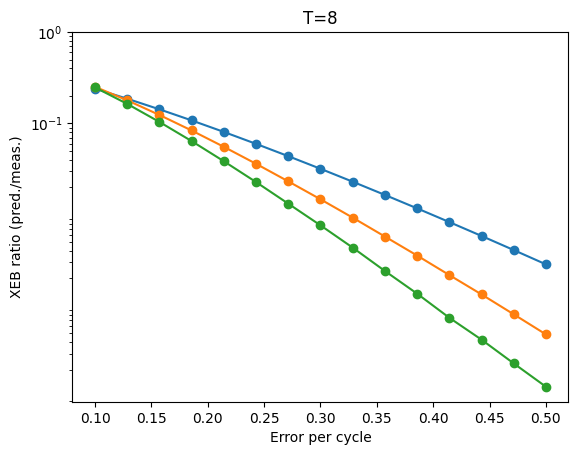

In [63]:

error_per_cycle = (e_paulis / (1 - 1/dim**2)) * 2 * N

for d in cycle_depths:
    ratios = res[d]
    plt.plot(error_per_cycle, ratios, label=f"{d}-th cycle", marker="o")
plt.xlabel("Error per cycle")
plt.ylabel("XEB ratio (pred./meas.)")
plt.yscale("log")
plt.yticks([1e-1, 1])
plt.title(f"T={link_freq}")
plt.show()

In [38]:
from sim.circuit import gen_1d_chain_xeb_random_circuit
circuits = [gen_1d_chain_xeb_random_circuit
    (
        qubits,
        depth=MAX_DEPTH,
        single_qubit_gates=SINGLE_QUBIT_GATES,
        two_qubit_op_factory=lambda a, b, _: cirq.SQRT_ISWAP(a, b)
    )
    for _ in range(n_circuits)
]
e_pauli = 3e-3
dim = 2 ** N
e_dep = e_pauli / (1 - 1/dim**2)
cycle_depths = list(range(30, 50, 4))
noise_model = cirq.devices.noise_model.ConstantQubitNoiseModel(cirq.depolarize(e_pauli))

xebs = np.mean([
    large_scale_xeb_sim(circuit, noise_model, cycle_depths=cycle_depths)
    for circuit in circuits
], axis=0)

8 qubits noisy state simulation: 100%|██████████| 93/93 [00:02<00:00, 33.70it/s]


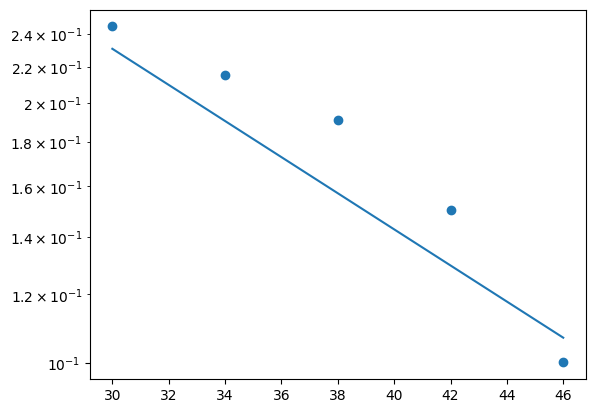

In [51]:
import matplotlib.pyplot as plt
cycle_depths = np.asarray(cycle_depths)
plt.scatter(cycle_depths, xebs, label="XEB", marker="o")
plt.plot(cycle_depths, (1 - e_dep) ** (N * (2 * cycle_depths + 1)))
plt.yscale("log")

In [49]:
e_pauli = 3e-3
dim = 2 ** N
e_dep = e_pauli / (1 - 1/dim**2)
(1 - e_dep) ** (2 * N)

0.9530643262078344

In [50]:
from sim.utils import _fit_exponential_decay

_fit_exponential_decay(cycle_depths, xebs)

/media/disk/Supremacy/xebsim/.venv/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/media/disk/Supremacy/xebsim/.venv/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new


(0.9999999999999999,
 0.9551399459709083,
 0.26914655004342186,
 0.007220415979096497)

In [22]:
np.log(2)

0.6931471805599453